In [1]:
import pandas as pd
import numpy as np
import csv

In [2]:
# Row limit while we write the code
limit=5000

In [3]:
def load_data():
    gnrl_cols_interest=['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
    'Physician_Profile_ID',
    'Physician_First_Name',
    'Physician_Middle_Name',
    'Physician_Last_Name',
    'Physician_Specialty',
    'Physician_Primary_Type',
    'Recipient_City',
    'Recipient_Province',
    'Recipient_State',
    'Recipient_Zip_Code',
    'Physician_Ownership_Indicator',
    'Program_Year',
    'Charity_Indicator',
    'Nature_of_Payment_or_Transfer_of_Value',                  
    'Record_ID',
    'Total_Amount_of_Payment_USDollars',
    'Number_of_Payments_Included_in_Total_Amount']
    general_payments=pd.read_csv('OP_DTL_GNRL_PGYR2013_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit).append(pd.read_csv('OP_DTL_GNRL_PGYR2014_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit)).append(pd.read_csv('OP_DTL_GNRL_PGYR2015_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit)).append(pd.read_csv('OP_DTL_GNRL_PGYR2016_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit))
    general_payments = general_payments[np.isfinite(general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'])]
    general_payments = general_payments[np.isfinite(general_payments['Physician_Profile_ID'])]
    general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID']=general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].apply(int).apply(str)
    general_payments['Physician_Profile_ID']=general_payments['Physician_Profile_ID'].apply(int).apply(str)
    print(general_payments.shape)
    print(general_payments.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID.nunique())
    print(general_payments.Physician_Profile_ID.nunique())
    return general_payments

In [7]:
def create_inputs(general_payments):
    grouped_payments_phys=general_payments.groupby(['Physician_Profile_ID','Program_Year'])['Total_Amount_of_Payment_USDollars','Number_of_Payments_Included_in_Total_Amount'].sum().reset_index()
    payment_phys=grouped_payments_phys.pivot(index='Physician_Profile_ID', columns='Program_Year', values='Total_Amount_of_Payment_USDollars').reset_index().replace(np.nan, 0, regex=True)
    num_payment_phys=grouped_payments_phys.pivot(index='Physician_Profile_ID', columns='Program_Year', values='Number_of_Payments_Included_in_Total_Amount').reset_index().replace(np.nan, 0, regex=True)
    phys_level=general_payments[['Physician_Profile_ID','Physician_Specialty','Physician_Primary_Type','Recipient_State']].drop_duplicates(subset='Physician_Profile_ID')
    phys_level=phys_level.join(phys_level.Physician_Specialty.str.split('|').str.join('|').str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    phys_level=phys_level.join(phys_level.Recipient_State.str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    phys_level=phys_level.join(phys_level.Physician_Primary_Type.str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    payment_phys['Physician_Profile_ID']=payment_phys['Physician_Profile_ID'].astype(str)
    num_payment_phys['Physician_Profile_ID']=num_payment_phys['Physician_Profile_ID'].astype(str)
    phys_level['Physician_Profile_ID']=phys_level['Physician_Profile_ID'].astype(str)
    phys_level=phys_level.merge(payment_phys.merge(num_payment_phys,how='left',on='Physician_Profile_ID'),how='left',on='Physician_Profile_ID').reset_index(drop=True)
    phys_level=phys_level.drop(['Physician_Specialty','Physician_Primary_Type','Recipient_State'], axis=1).replace(np.nan, 0, regex=True)
    return phys_level

In [8]:
def preprocess(data,pca_flag,numcomps):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    X_data = data.iloc[:,1:].replace(np.nan, 0, regex=True).values
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1),copy=False)
    X_data = scaler.fit_transform(X_data)
    X_data_viz = TSNE(n_components=2).fit_transform(X_data)
    if pca_flag==1:
        X_data=TSNE(n_components=numcomps).fit_transform(X_data)   
        X_data_viz=X_data
    return X_data,X_data_viz

In [9]:
general_payments=load_data()
phys_level=create_inputs(general_payments)

X_phys,X_phys_viz = preprocess(phys_level,1,2)


(19925, 21)
56
11633
Index(['Physician_Profile_ID', 'Program_Year',
       'Nature_of_Payment_or_Transfer_of_Value',
       'Total_Amount_of_Payment_USDollars',
       'Number_of_Payments_Included_in_Total_Amount'],
      dtype='object')


KeyError: 'Level Program_Year not found'

In [139]:
nclust=4
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nclust)
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
agglo1=AgglomerativeClustering(n_clusters=nclust,linkage='complete')
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X_phys, n_neighbors=30, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
minibatch = cluster.MiniBatchKMeans(n_clusters=nclust)
agglo2= cluster.AgglomerativeClustering(n_clusters=nclust, linkage='ward',connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=nclust, eigen_solver='arpack',affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=0.3, min_samples=10)
agglo3= cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=nclust, connectivity=connectivity)
birch = cluster.Birch(n_clusters=nclust)
gmm = mixture.GaussianMixture(n_components=nclust, covariance_type='full')
phys_labels=pd.DataFrame()
try:
    kmeans.fit(X_phys)
    labels_kmeans=kmeans.predict(X_phys)
    phys_labels['labels_kmeans']=labels_kmeans
except:
    pass
try:
    labels_agglo1=agglo1.fit_predict(X_phys)  
    phys_labels['labels_agglo1']=labels_agglo1
except:
    pass
try:
    labels_spectral=spectral.fit_predict(X_phys)  
    phys_labels['labels_spectral']=labels_spectral
except:
    pass
try:
    labels_agglo2=agglo2.fit_predict(X_phys)
    phys_labels['labels_agglo2']=labels_agglo2
except:
    pass
try:
    labels_agglo3=agglo3.fit_predict(X_phys)
    phys_labels['labels_agglo3']=labels_agglo3
except:
    pass
try:
    minibatch.fit(X_phys)
    labels_minibatch=minibatch.predict(X_phys)
    phys_labels['labels_minibatch']=labels_minibatch
except:
    pass
try:
    labels_dbscan=dbscan.fit_predict(X_phys)
    phys_labels['labels_dbscan']=labels_dbscan
except:
    pass
try:
    birch.fit(X_phys)
    labels_birch=birch.predict(X_phys)
    phys_labels['labels_birch']=labels_birch
except:
    pass
try:
    gmm.fit(X_phys)
    labels_gmm=gmm.predict(X_phys)
    phys_labels['labels_gmm']=labels_gmm
except:
    pass

/Users/smh/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/smh/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 60 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/Users/smh/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 60 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


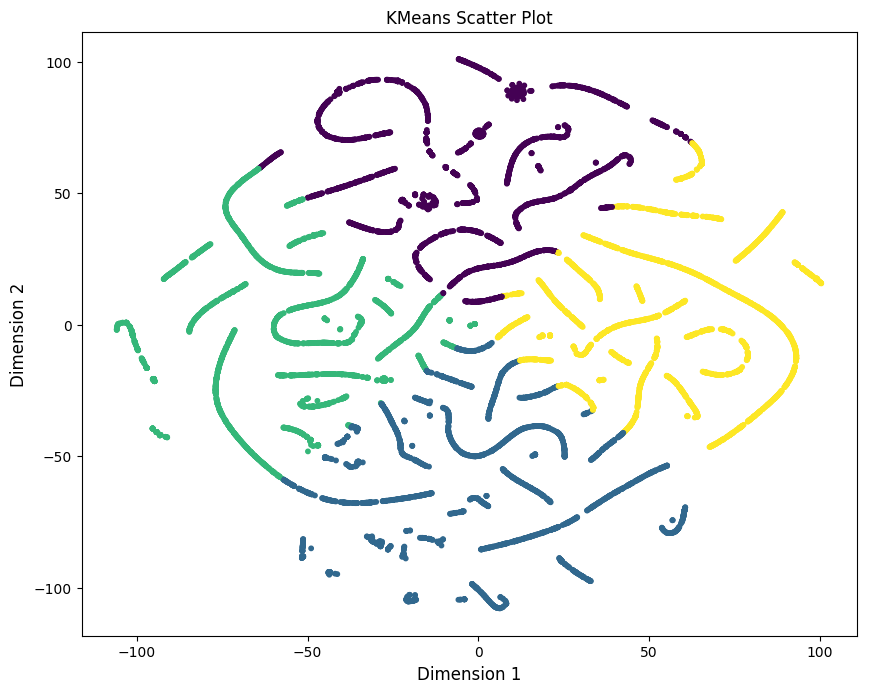

In [140]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]

plt.figure(figsize=(10, 8), dpi=100)
plt.title('KMeans Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_kmeans'],s=10, cmap='viridis');
plt.show()

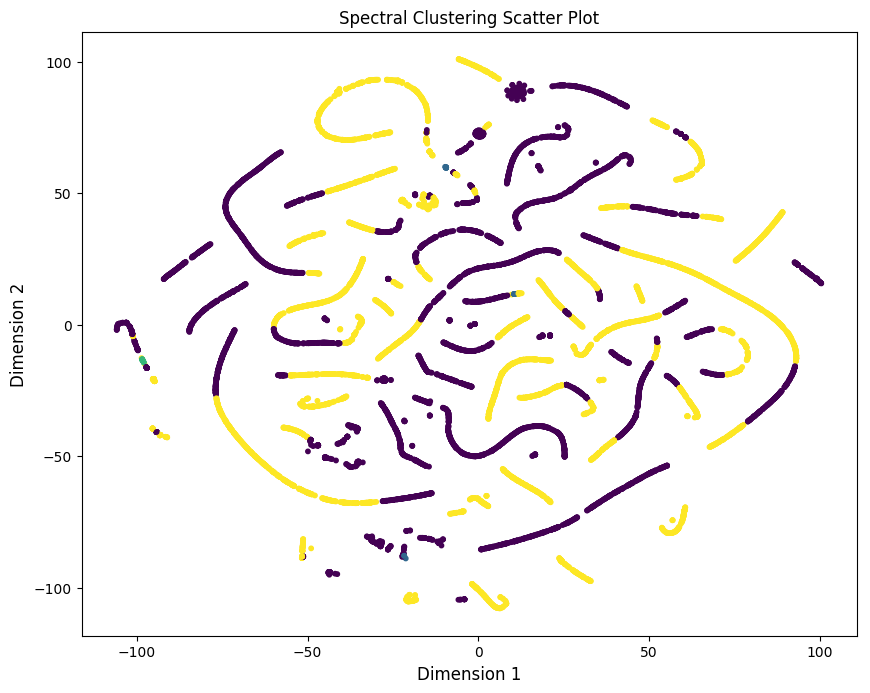

In [141]:
import matplotlib.pyplot as plt

phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]

plt.figure(figsize=(10, 8), dpi=100)
plt.title('Spectral Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)


plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_spectral'],s=10, cmap='viridis');
plt.show()

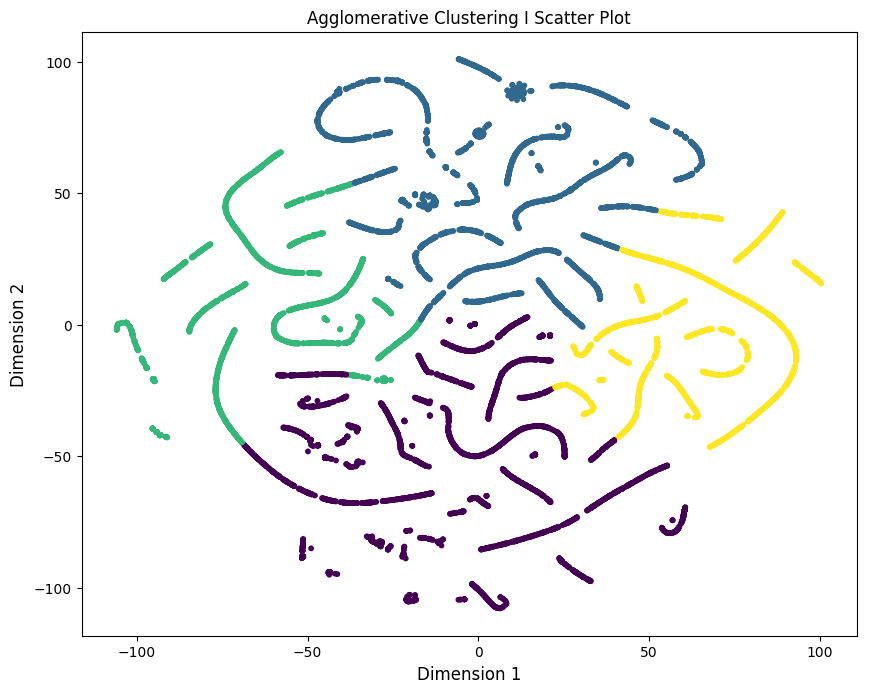

In [142]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]

plt.figure(figsize=(10, 8), dpi=100)
plt.title('Agglomerative Clustering I Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_agglo1'],s=10, cmap='viridis');
plt.show()

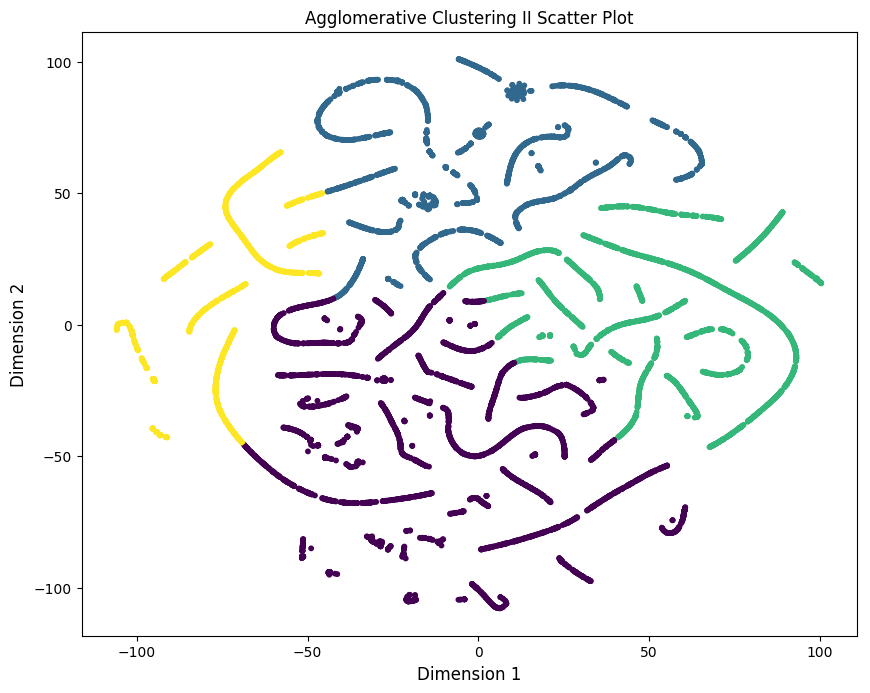

In [143]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]


plt.figure(figsize=(10, 8), dpi=100)
plt.title('Agglomerative Clustering II Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_agglo2'],s=10, cmap='viridis');
plt.show()

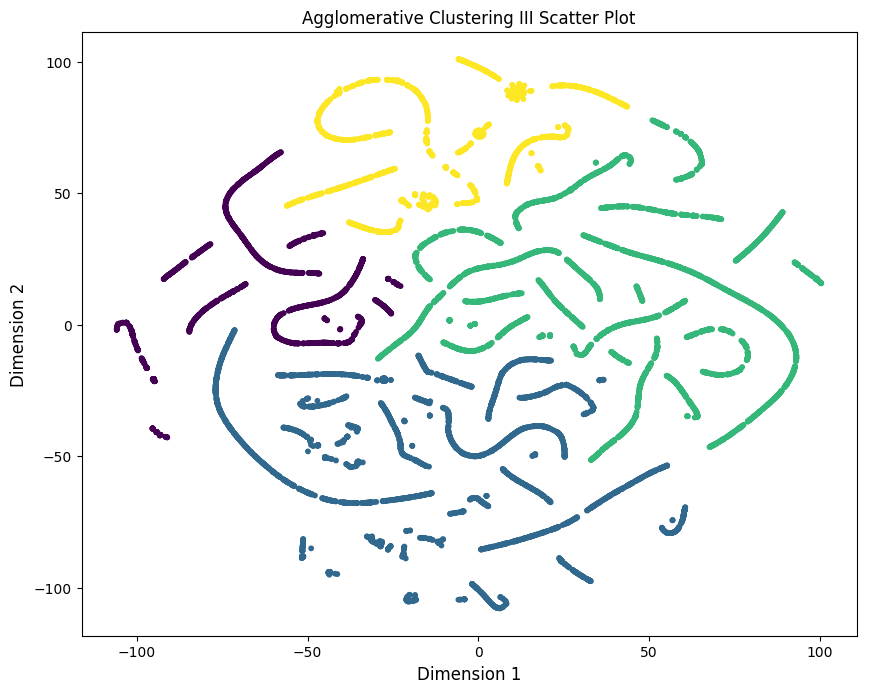

In [144]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]


plt.figure(figsize=(10, 8), dpi=100)
plt.title('Agglomerative Clustering III Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_agglo3'],s=10, cmap='viridis');
plt.show()

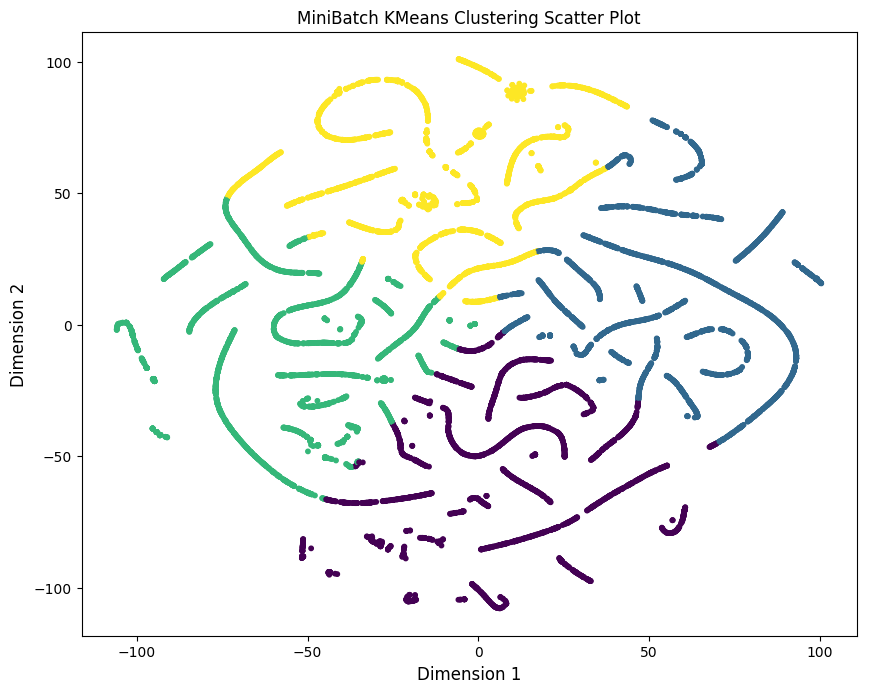

In [145]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]



plt.figure(figsize=(10, 8), dpi=100)
plt.title('MiniBatch KMeans Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_minibatch'],s=10, cmap='viridis');
plt.show()

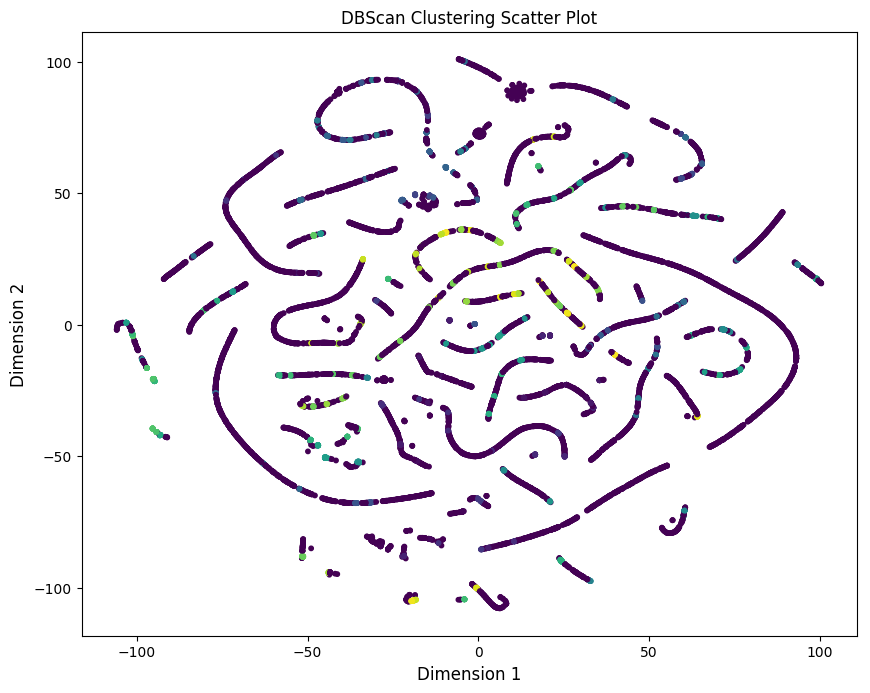

In [146]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]

plt.figure(figsize=(10, 8), dpi=100)
plt.title('DBScan Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_dbscan'],s=10, cmap='viridis');
plt.show()

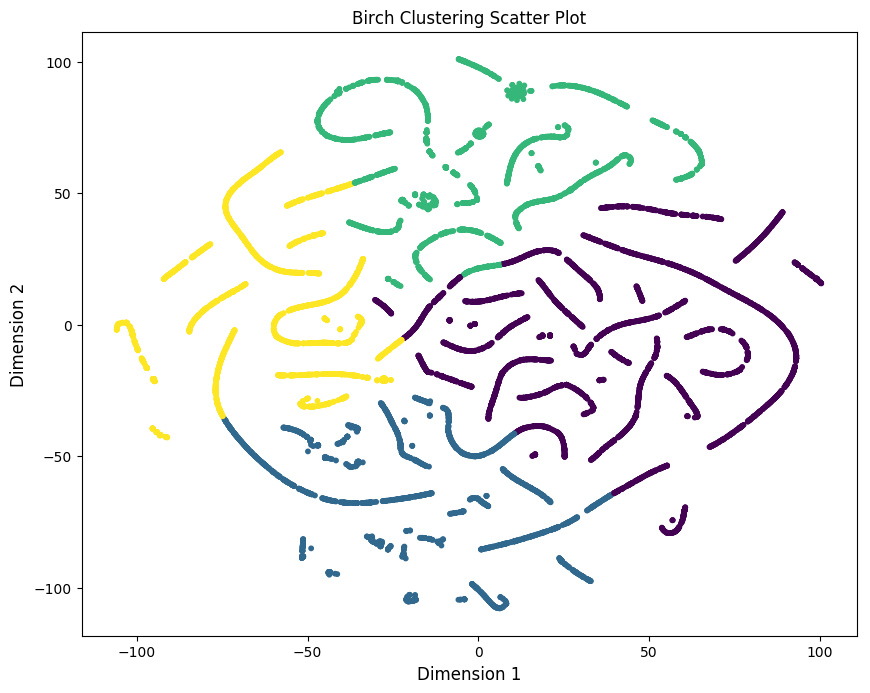

In [147]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]

plt.figure(figsize=(10, 8), dpi=100)
plt.title('Birch Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_birch'],s=10, cmap='viridis');
plt.show()

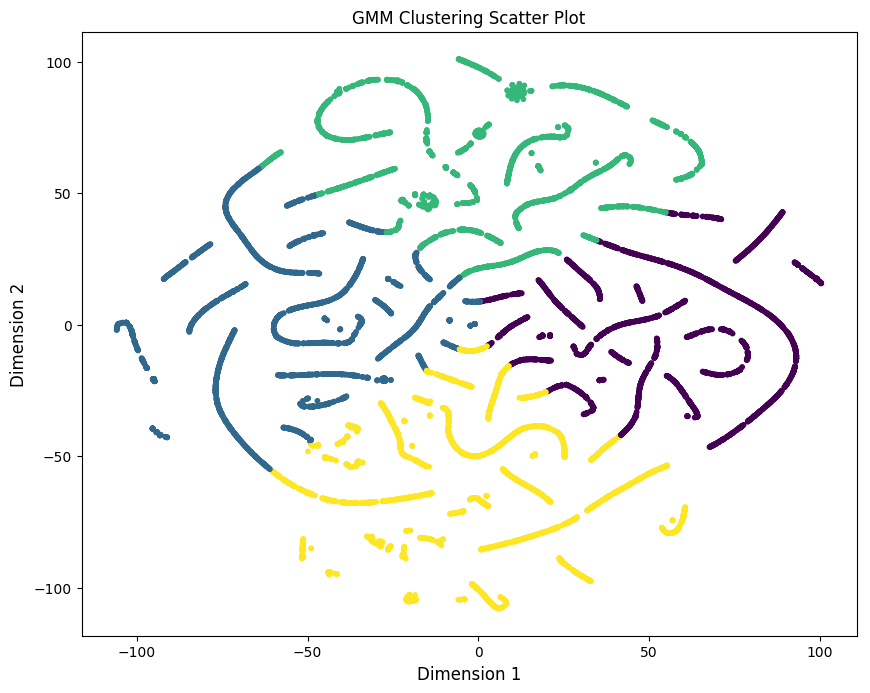

In [148]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]


plt.figure(figsize=(10, 8), dpi=100)
plt.title('GMM Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_gmm'],s=10, cmap='viridis');
plt.show()

In [149]:
general_payments_clus=general_payments.merge(phys_labels, left_on='Physician_Profile_ID', right_on='Physician_Profile_ID', how='left')

Algorithm: KMeans


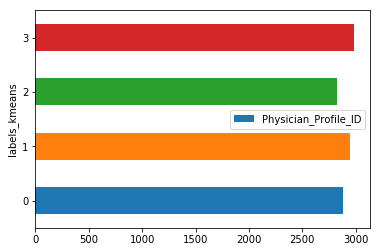

In [150]:
print("Algorithm: KMeans")
general_payments_clus.groupby('labels_kmeans')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


Algorithm: KMeans


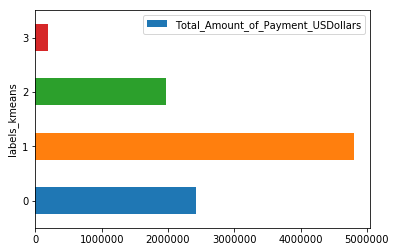

In [151]:
print("Algorithm: KMeans")
%matplotlib inline
general_payments_clus.groupby('labels_kmeans')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Spectral Clustering


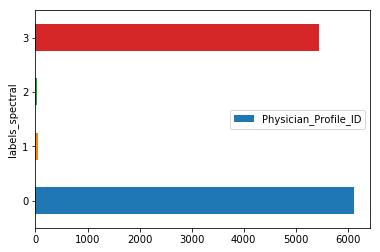

In [152]:
print("Algorithm: Spectral Clustering")
%matplotlib inline
general_payments_clus.groupby('labels_spectral')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


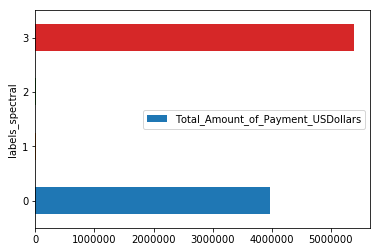

In [153]:
general_payments_clus.groupby('labels_spectral')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Agglomerative Clustering I


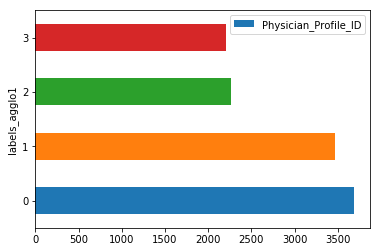

In [154]:
print("Algorithm: Agglomerative Clustering I")
%matplotlib inline
general_payments_clus.groupby('labels_agglo1')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

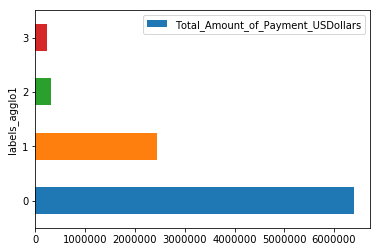

In [155]:
general_payments_clus.groupby('labels_agglo1')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Agglomerative Clustering II


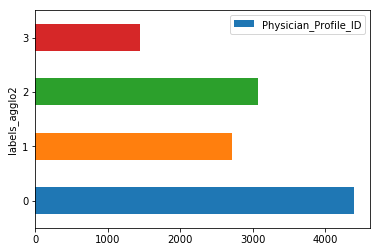

In [156]:
print("Algorithm: Agglomerative Clustering II")
%matplotlib inline
general_payments_clus.groupby('labels_agglo2')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


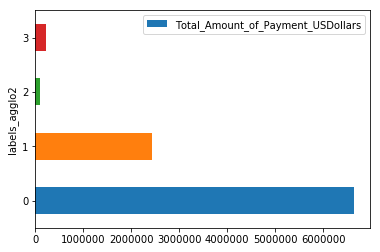

In [157]:
general_payments_clus.groupby('labels_agglo2')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Agglomerative Clustering III


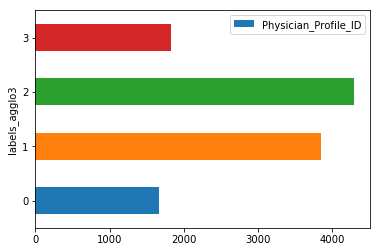

In [158]:
print("Algorithm: Agglomerative Clustering III")
%matplotlib inline
general_payments_clus.groupby('labels_agglo3')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


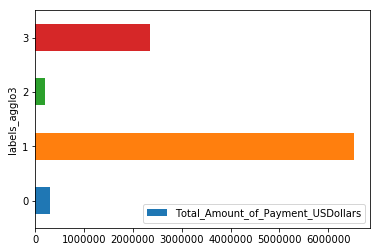

In [159]:
general_payments_clus.groupby('labels_agglo3')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Minibatch


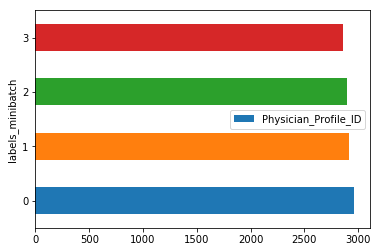

In [160]:
print("Algorithm: Minibatch")
%matplotlib inline
general_payments_clus.groupby('labels_minibatch')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


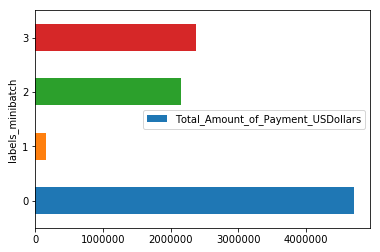

In [161]:
general_payments_clus.groupby('labels_minibatch')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: DBScan


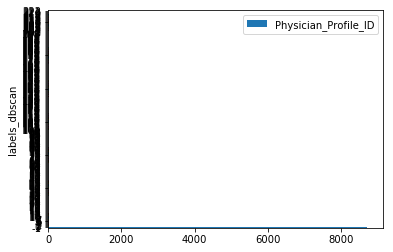

In [169]:
print("Algorithm: DBScan")
%matplotlib inline
general_payments_clus.groupby('labels_dbscan')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


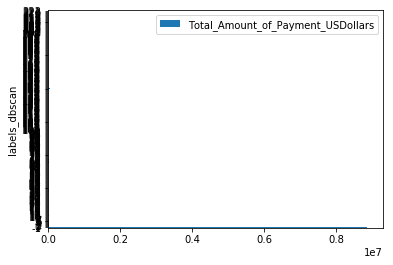

In [163]:
general_payments_clus.groupby('labels_dbscan')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: Birch


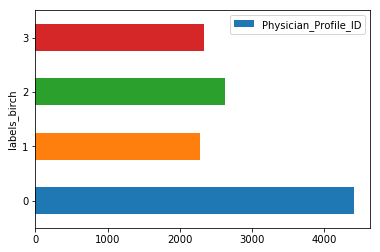

In [164]:
print("Algorithm: Birch")
%matplotlib inline
general_payments_clus.groupby('labels_birch')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


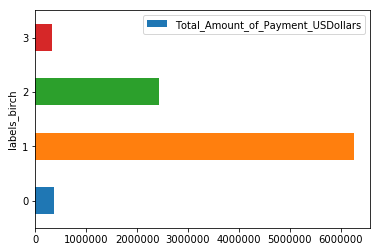

In [165]:
general_payments_clus.groupby('labels_birch')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

Algorithm: GMM


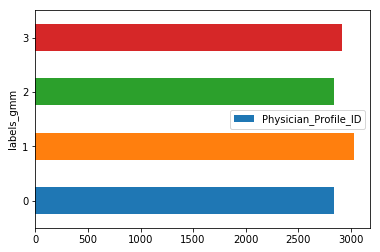

In [166]:
print("Algorithm: GMM")
%matplotlib inline
general_payments_clus.groupby('labels_gmm')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)


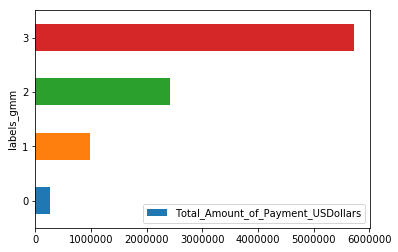

In [167]:
general_payments_clus.groupby('labels_gmm')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

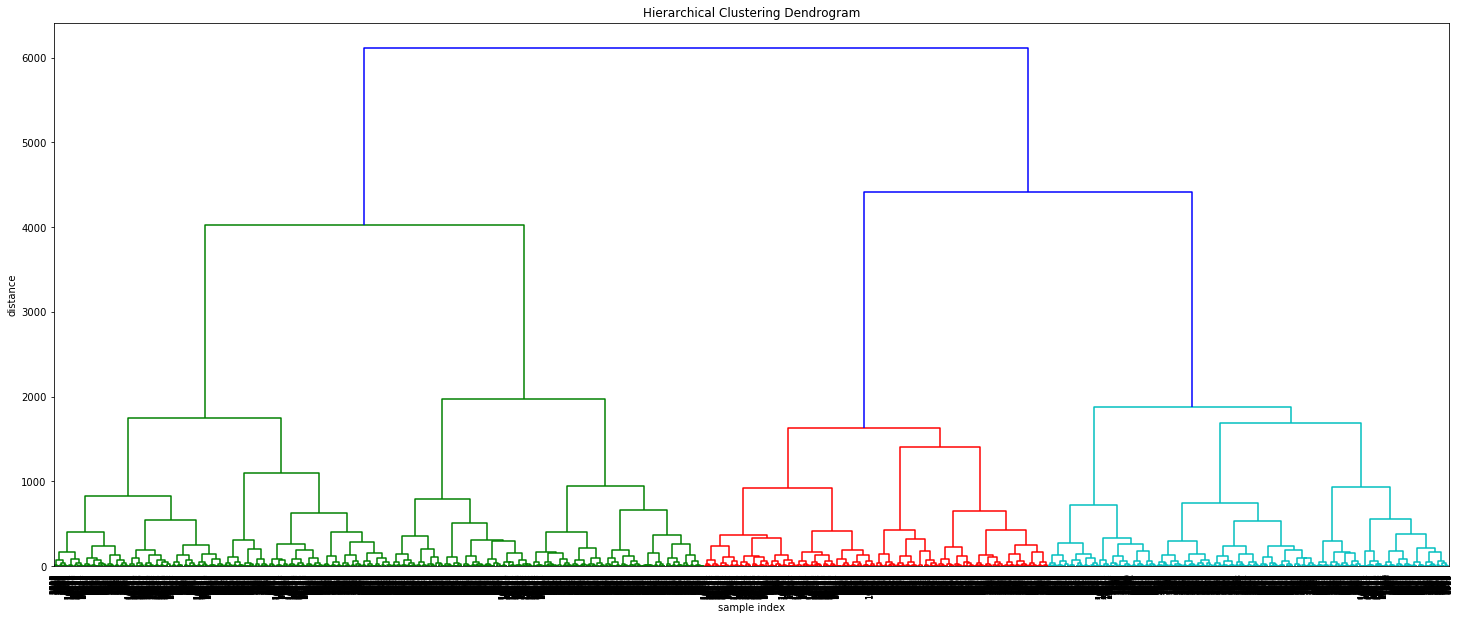

In [168]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X_phys, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X_phys))

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()